In [1]:
import os
from skimage.metrics import structural_similarity as ssim
from skimage.transform import resize
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [2]:
from img_compare import *
from reddit_img_classifier import *

In [3]:
logging.getLogger('root').setLevel(logging.WARNING)

# Note: modify this to get detailed logging messages to see progress

# Introduction

This is a showcase of some image comparison functions and how I use them to try and group Reddit memes together to identify popular meme formats.

I will be using three different image comparison metrics to determine similarity: Mean Squared Error (MSE), Structural Similarity Measure (SSIM), and image hashing.

### Mean Squared Error (MSE)

The Mean Squared Error (MSE) between the two images is the sum of the squared difference between the two images.

It's pretty simple to implement, but it is a decent measure of similarity. It only functions on images of the same size.

MSE has some limitations. For example, large distances between pixel intensities, such as contrasted images, do not necessarily mean the image is not similar. Also, MSE only works on images of the same size.

Note that lower MSEs mean more similar images.

### Structural Similarity Measure (SSIM)

The Structural Similarity Measure (SSIM). SSIM attempts to model the perceived change in the structural information of the image.

Essentially, the main benefit of SSIM is that it accounts for texture. It measures similarity, just as MSE, but takes into account image quality.

SSIM is likely the strictest of the three measures used to indicate image similarity.

SSIM also only works on images of the same size. From testing, SSIM seems to work better when smaller images are resized to fit the larger than the opposite direction (larger images being resized to fit smaller).

Note that higher SSIMs reflect more similarity.

The SSIM function used for image comparison is imported from the [scikit-image library](https://scikit-image.org/)

### Image Hashing

Image hashing or perceptual hashing is the process of examining the contents of an image and then constructing a hash value that uniquely identifies an input image based on the contents of the image.

Essentially, it narrows the image down to a set of unique features and assigns it a value based on those features.

The image hashes of two similar images will be more similar than the image hashes of two different images. Therefore, by subtracting the image hashes, one can get a rough measure of how similar two images are.

Image hashing works regardless of image size.

Note that a lower hash difference means the images are more similar.

# Examples

Let's see some example images and how they compare using our similarity measures.

Run the following block to see all available test images:

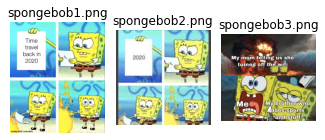

In [4]:
test_image_paths = img_folder_plot(TEST_IMG_PATH)
imgA = cv2.imread(test_image_paths[0])
imgB = cv2.imread(test_image_paths[1])
imgC = cv2.imread(test_image_paths[2])

Let's compare all the various images now. As can be seen, spongebob1.png and spongebob2.png are the same meme format, so they should be more similar. spongebob3.png should have a notably worse similarity score.

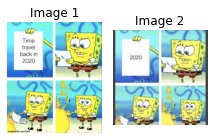

MSE: 0.07560973075958617
SSIM: 0.6437364351044425
HASH: 23


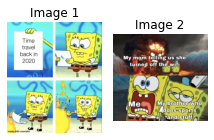

MSE: 0.23747421165086122
SSIM: 0.4032295038558613
HASH: 32


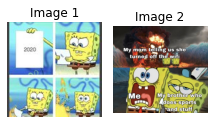

MSE: 0.228390133086145
SSIM: 0.35620894495679245
HASH: 35


In [5]:
compare_all_images([imgA, imgB, imgC], visualize=True)

As can be seen the two images with the same meme format have lower MSEs, higher SSIMs, and lower hash differences than images with different meme formats.

Although, the scores may still be a bit off from what you may have expected.

For example, why do the images with the same meme format still have such a low SSIM and such a high hash?

It's important to remember SSIM measures texture, making it perhaps the strictest of the three measures. Memes come in many different qualities, so SSIM, while still showing similarity, will be harsher towards different quality images.

Hashes are used to compare when images are nearly identical. Not just the different quality but the different text affects how well hashes work, although of course they still reflect the similarity of the two images.

SSIM and Hashes are both stricter metrics than MSE. Although, they are both still important. For example, SSIM will be more resistant to contrasting a meme format (a common practice) relative to MSE.

# Basic Classification

Given any one of MSE, SSIM, or hash difference, it would not be too difficult to write a simple function to determine similarity.

The code in img_compare.py contains a det_similar function that uses all three (MSE, SSIM, hash_diff) as a tuple called a "similarity_score" throughout the code (although I didn't bother with OOP for this).

det_similar accepts either two images or a similarity score, and returns a boolean. 

Currently, it's rather naive, and calls images similar if any of the metrics qualifies for similarity. 

In the below code block for your convenience is the det_similar function. It's identical to the one in the code, so running it shouldn't change anything.

In [6]:
def det_similar(imgA=None, imgB=None, similarity_score=None, \
        MSE_cutoff=MSE_CUTOFF, SSIM_cutoff=SSIM_CUTOFF, HASH_cutoff=HASH_CUTOFF):
    '''Returns True or False if two images are deemed similar.'''
    assert imgA and imgB and not similarity_score \
            or similarity_score and not imgA and not imgB
    if not similarity_score and imgA and imgB:
        similarity_score = compare_images(imgA, imgB)
    if similarity_score[0] < MSE_cutoff or similarity_score[1] > SSIM_cutoff or\
        similarity_score[2] < HASH_cutoff:
        return True
    return False

Classifying isn't too hard with this function to determine similarity. My function simply assigns the first image in a list as the first image in the category. Then it iterates through the rest of the list to determine similarity. If similarity is found, it appends the image to the category and removes it from the image list.

## Example

Let's see my basic similarity determination and classification in action with the test images from above.

Category 1:


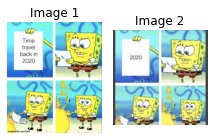

Category 2:


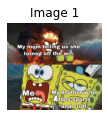

In [7]:
classifier_func([imgA, imgB, imgC], visualize=True);

As can be seen, this classification works for the test images. Although, there are only three of them, and they are pretty clearly distinct. Let's try with some more images.

# Classifying Reddit Posts

The comparisons above can also be used to classify image posts on popular media aggregation site Reddit. In particular, the image posts we will be classifying will all be (or all should be) memes.

Memes are hopefully much easier to classify than other types of images because they mainly all follow a format. For example, the two different 2020 Spongebob memes above both use the same meme format. This makes it easy to categorize them by similarity.

## The Python Reddit API Wrapper (PRAW)

Luckily, Reddit has an API to be able to easily collect information about posts. For Python, this is the Python Reddit API Wrapper (PRAW).

The code block below gets the top post_num image posts from the subreddit r/ProgrammerHumor from the past month. It shows only the first 20.

If you're viewing this on Jupyter Notebook, you can edit these values. I advise picking a subreddit that's based solely on memes.

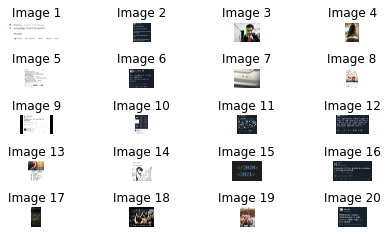

In [8]:
images = get_top_images(
    subreddit='ProgrammerHumor',
    time='month',
    post_num=50
)
show_images(images, show=20)

Let's check for any similar images, ideally meme formats, using our classifer.

Category 1:


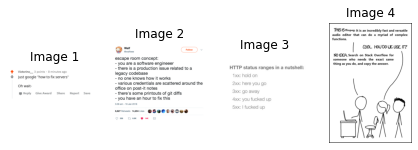

Category 2:


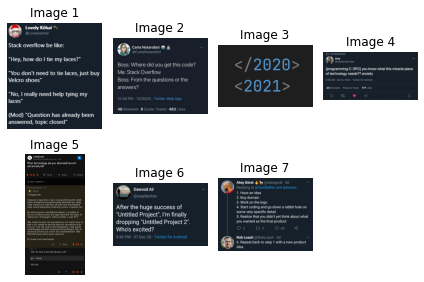

Category 3:


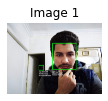

Category 4:


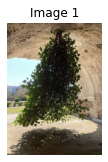

Category 5:


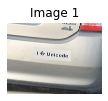

Category 6:


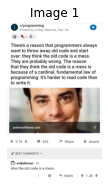

Category 7:


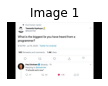

Category 8:


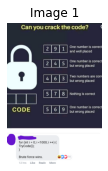

Category 9:


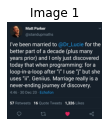

Category 10:


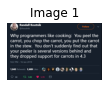

Category 11:


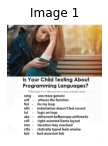

Category 12:


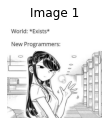

Category 13:


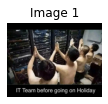

Category 14:


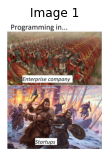

Category 15:


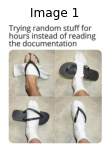

Category 16:


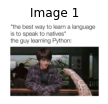

Category 17:


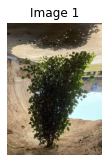

Category 18:


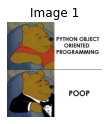

Category 19:


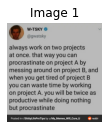

Category 20:


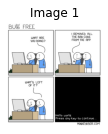

Category 21:


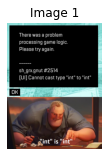

Category 22:


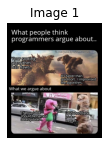

Category 23:


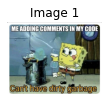

Category 24:


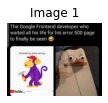

Category 25:


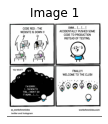

Category 26:


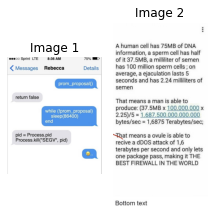

Category 27:


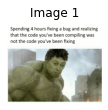

Category 28:


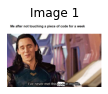

Category 29:


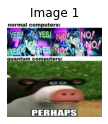

Category 30:


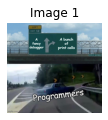

Category 31:


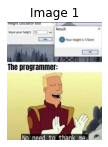

Category 32:


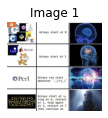

Category 33:


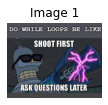

Category 34:


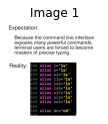

Category 35:


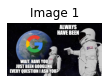

Category 36:


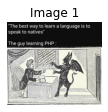

Category 37:


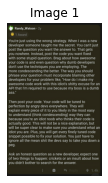

Category 38:


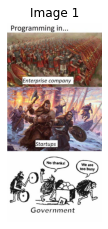

Category 39:


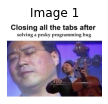

Category 40:


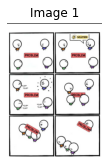

In [9]:
classifier_func(images, visualize=True);

As can be seen, the classifier does classify similar images. Although, those similar images aren't necessarily memes as I would've hoped.

For example, many Twitter posts (a common post on r/ProgrammerHumor and many other subreddits) were classified the same since they're generally very similar images. Also, many photos that are mainly just black text on a white background suffered the same fate.

Ideally, the det_similarity function will be more strict with what it considers similar.

Another problem is that there are surprisingly few similar meme formats. This is likely because images are taken from the top posts and not the hot or new posts, where similar meme formats are more likely. Alternatively, there are also so many meme formats that it would be more accurate to compile thousands of posts than just the few I did. I didn't want to take too large of a batch for a showcase though.

Overall, while the program failed to classify meme formats in this example, it did classify similar images and showed potential to classify meme formats given more data and a better subreddit.

# Improvements

* Improve the det_similarity function to more accurately capture similar images.


* Optimize speed. Right now, this code runs VERY slowly it's (if I have my big O's correct, which I might not) O(n^3). Larger batches take very long to process. There are points where optimization is clearly possible here.